## Conexión a Snowflake

In [1]:
import matplotlib.pyplot as plt
import snowflake.connector
import seaborn as sns
import pandas as pd
import numpy as np
import os

USER = os.getenv('SNOWFLAKE_USER')
PASSWORD = os.getenv('SNOWFLAKE_PASSWORD')
ACCOUNT = os.getenv('SNOWFLAKE_ACCOUNT')
WAREHOUSE = os.getenv('SNOWFLAKE_DEFAULT_WH')
DATABASE = os.getenv('SNOWFLAKE_DEFAULT_DB')
SCHEMA = os.getenv('SNOWFLAKE_DEFAULT_SCHEMA')
ROLE = os.getenv('SNOWFLAKE_ROLE')

conn = snowflake.connector.connect(
    user=USER,
    password=PASSWORD,
    account=ACCOUNT,
    warehouse=WAREHOUSE,
    database=DATABASE,
    schema=SCHEMA,
    role=ROLE
    )

## Funciones para analizar dataframes

In [ ]:
# Función para gráficar histogramas de variables numéricas (hecho con ayuda de deepseek r1)
def plot_numeric_analysis(df, numeric_cols, figsize=(15, 10)):
    """Gráfica histogramas de variables numéricas."""
    if not numeric_cols:
        print("No hay columnas numéricas para graficar.")
        return
    
    n_cols = min(3, len(numeric_cols))
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    
    if len(numeric_cols) <= 2:
        figsize = (8, 5)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle('Análisis de Variables Numéricas', fontsize=16)
    
    # Aplanar los ejes para simplificar la iteración
    axes = np.array(axes).flatten() if isinstance(axes, np.ndarray) else np.array([axes])
    
    for idx, col in enumerate(numeric_cols):
        sns.histplot(data=df, x=col, ax=axes[idx])
        axes[idx].set_title(f'Distribución de {col}')
    
    # Ocultar subplots no utilizados
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Función para detectar outlayers con el método IQR, extremos y no extremos
def iqr_method(column):
    """Detecta outliers usando el método IQR."""
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    extreme_lower_bound = q1 - 3 * iqr
    extreme_upper_bound = q3 + 3 * iqr
    return pd.Series([column>upper_bound, column<lower_bound, column>extreme_upper_bound, column<extreme_lower_bound], 
                     index=['outliers_upper', 'outliers_lower', 'extreme_upper', 'extreme_lower'])

# Función para realizar un análisis exploratorio de una tabla (mejorado con ayuda de claude 3.5 sonnet)
def analisis_exploratorio(name, df):
    """Realiza un análisis exploratorio de una tabla."""
    total_chars = 125
    print("="*total_chars)
    string = f"Análisis de la tabla {name}"
    print('|' + string.center(total_chars-2) + '|')
    print("="*total_chars)
    print(f"Dimensiones: {df.shape}")
    
    # Separar columnas numéricas y no numéricas
    id_cols = [col for col in df.columns if 'ID' in col]
    numeric_cols = list(df.select_dtypes(include=['int64', 'float64']).columns)
    numeric_cols = [col for col in numeric_cols if col not in id_cols]
    non_numeric_cols = list(df.select_dtypes(exclude=['int64', 'float64']).columns)
    # Convert non-numeric columns to lowercase and strip whitespace, only for non-null values
    for col in non_numeric_cols:
        df[col] = df[col].apply(lambda x: x.lower().strip() if pd.notna(x) else x)
    non_numeric_cols += id_cols

    non_numeric_stats = []
    if non_numeric_cols:
        for col in non_numeric_cols:
            non_numeric_stats.append({
                'Columna': col,
                'Valores Únicos': df[col].nunique(),
                'Media': '-',
                'Desviación Estándar': '-',
                'Mínimo': df[col].min() if ('ID' in col) else '-',
                'Mediana': '-',
                'Máximo': df[col].max() if ('ID' in col) else '-'
            })
    
    numeric_stats = []
    if numeric_cols:
        for col in numeric_cols:
            if df[col].nunique() == 2 and set(df[col].dropna().unique()).issubset({0, 1}):
                df[col] = df[col].astype('boolean')
                numeric_cols.remove(col)
            numeric_stats.append({
                'Columna': col,
                'Valores Únicos': df[col].nunique(),
                'Media': df[col].mean() if df[col].dtype != 'boolean' else '-',
                'Desviación Estándar': df[col].std() if df[col].dtype != 'boolean' else '-',
                'Mínimo': df[col].min() if df[col].dtype != 'boolean' else '-',
                'Mediana': df[col].median() if df[col].dtype != 'boolean' else '-',
                'Máximo': df[col].max() if df[col].dtype != 'boolean' else '-'
            })
    
    combined_stats = non_numeric_stats + numeric_stats
    combined_stats_df = pd.DataFrame(combined_stats).set_index('Columna').T
    
    print('\nEstadísticos descriptivos básicos:')
    print(combined_stats_df.to_markdown(index=True))

    
    inconsistencias_stats = []
    for col in df.columns:
        inconsistencias_stats.append({
            'Columna': col,
            'Tipos de datos presentes': df[col].apply(type).unique() if len(df[col].apply(type).unique()) == 1 else '\n'.join(str(t) for t in df[col].apply(type).unique()),
            'NaN/Null': df[col].isnull().sum(),
            'Duplicados únicos': len(df[(df.duplicated(subset=[col], keep='first'))&(df[col].notnull())]),
            'Duplicados totales': len(df[(df.duplicated(subset=[col], keep=False))&(df[col].notnull())]),
            'Outlayers (IQR extreme_lower)': iqr_method(df[col])['extreme_lower'].sum() if pd.api.types.is_numeric_dtype(df[col]) and col in numeric_cols else '-',
            'Outlayers (IQR lower)': iqr_method(df[col])['outliers_lower'].sum() if pd.api.types.is_numeric_dtype(df[col]) and col in numeric_cols else '-',
            'Outlayers (IQR upper)': iqr_method(df[col])['outliers_upper'].sum() if pd.api.types.is_numeric_dtype(df[col]) and col in numeric_cols else '-',
            'Outlayers (IQR extreme_upper)': iqr_method(df[col])['extreme_upper'].sum() if pd.api.types.is_numeric_dtype(df[col]) and col in numeric_cols else '-'
        })
    inconsistencias_stats_df = pd.DataFrame(inconsistencias_stats).set_index('Columna').T

    print('\nProblemas de calidad:')
    print(inconsistencias_stats_df.to_markdown(index=True))
    
    if numeric_cols:
        plot_numeric_analysis(df, numeric_cols)
    return

## Análisis exploratorio

In [3]:
table_name = 'AISLES'
result = conn.cursor().execute(f'SELECT * FROM {table_name}')
df = pd.DataFrame(result.fetchall(), columns=[desc[0] for desc in result.description])
analisis_exploratorio(table_name, df)

|                                                Análisis de la tabla AISLES                                                |
Dimensiones: (134, 2)

Estadísticos descriptivos básicos:
|                     | AISLE   | AISLE_ID   |
|:--------------------|:--------|:-----------|
| Valores Únicos      | 134     | 134        |
| Media               | -       | -          |
| Desviación Estándar | -       | -          |
| Mínimo              | -       | 1          |
| Mediana             | -       | -          |
| Máximo              | -       | 134        |

Problemas de calidad:
|                               | AISLE_ID        | AISLE           |
|:------------------------------|:----------------|:----------------|
| Tipos de datos presentes      | [<class 'int'>] | [<class 'str'>] |
| NaN/Null                      | 0               | 0               |
| Duplicados únicos             | 0               | 0               |
| Duplicados totales            | 0               | 0              

El análisis de la tabla AISLES revela que cuenta con 134 filas y 2 columnas, presentando un total de 134 valores únicos tanto en AISLE como en AISLE_ID. No se identificaron problemas de calidad, ya que no hay valores ausentes, duplicados, ni inconsistencias en los datos esta tabla parece estar en buen estado para ser utilizada en análisis posteriores. La misma contendría información sobre los pasillos de la tienda.

In [4]:
table_name = 'DEPARTMENTS'
result = conn.cursor().execute(f'SELECT * FROM {table_name}')
df = pd.DataFrame(result.fetchall(), columns=[desc[0] for desc in result.description])
analisis_exploratorio(table_name, df)

|                                              Análisis de la tabla DEPARTMENTS                                             |
Dimensiones: (21, 2)

Estadísticos descriptivos básicos:
|                     | DEPARTMENT   | DEPARTMENT_ID   |
|:--------------------|:-------------|:----------------|
| Valores Únicos      | 21           | 21              |
| Media               | -            | -               |
| Desviación Estándar | -            | -               |
| Mínimo              | -            | 1               |
| Mediana             | -            | -               |
| Máximo              | -            | 21              |

Problemas de calidad:
|                               | DEPARTMENT_ID   | DEPARTMENT      |
|:------------------------------|:----------------|:----------------|
| Tipos de datos presentes      | [<class 'int'>] | [<class 'str'>] |
| NaN/Null                      | 0               | 0               |
| Duplicados únicos             | 0               | 0     

El análisis de la tabla DEPARTMENTS revela que cuenta con 21 filas y 2 columnas, presentando un total de 21 valores únicos tanto en DEPARTMENT como en DEPARTMENT_ID. No se identificaron problemas de calidad, ya que no hay valores ausentes, duplicados, ni inconsistencias en los datos esta tabla parece estar en buen estado para ser utilizada en análisis posteriores. La misma contendría información sobre los pasillos de la tienda.

|                                                Análisis de la tabla ORDERS                                                |
Dimensiones: (478967, 6)

Estadísticos descriptivos básicos:
|                     | ORDER_ID   | USER_ID   |   ORDER_NUMBER |   ORDER_DOW |   ORDER_HOUR_OF_DAY |   DAYS_SINCE_PRIOR_ORDER |
|:--------------------|:-----------|:----------|---------------:|------------:|--------------------:|-------------------------:|
| Valores Únicos      | 478952     | 157437    |       100      |     7       |            24       |                 31       |
| Media               | -          | -         |        17.1578 |     2.77506 |            13.4467  |                 11.1018  |
| Desviación Estándar | -          | -         |        17.7047 |     2.04587 |             4.22499 |                  9.18997 |
| Mínimo              | 4.0        | 2.0       |         1      |     0       |             0       |                  0       |
| Mediana             | -          | - 

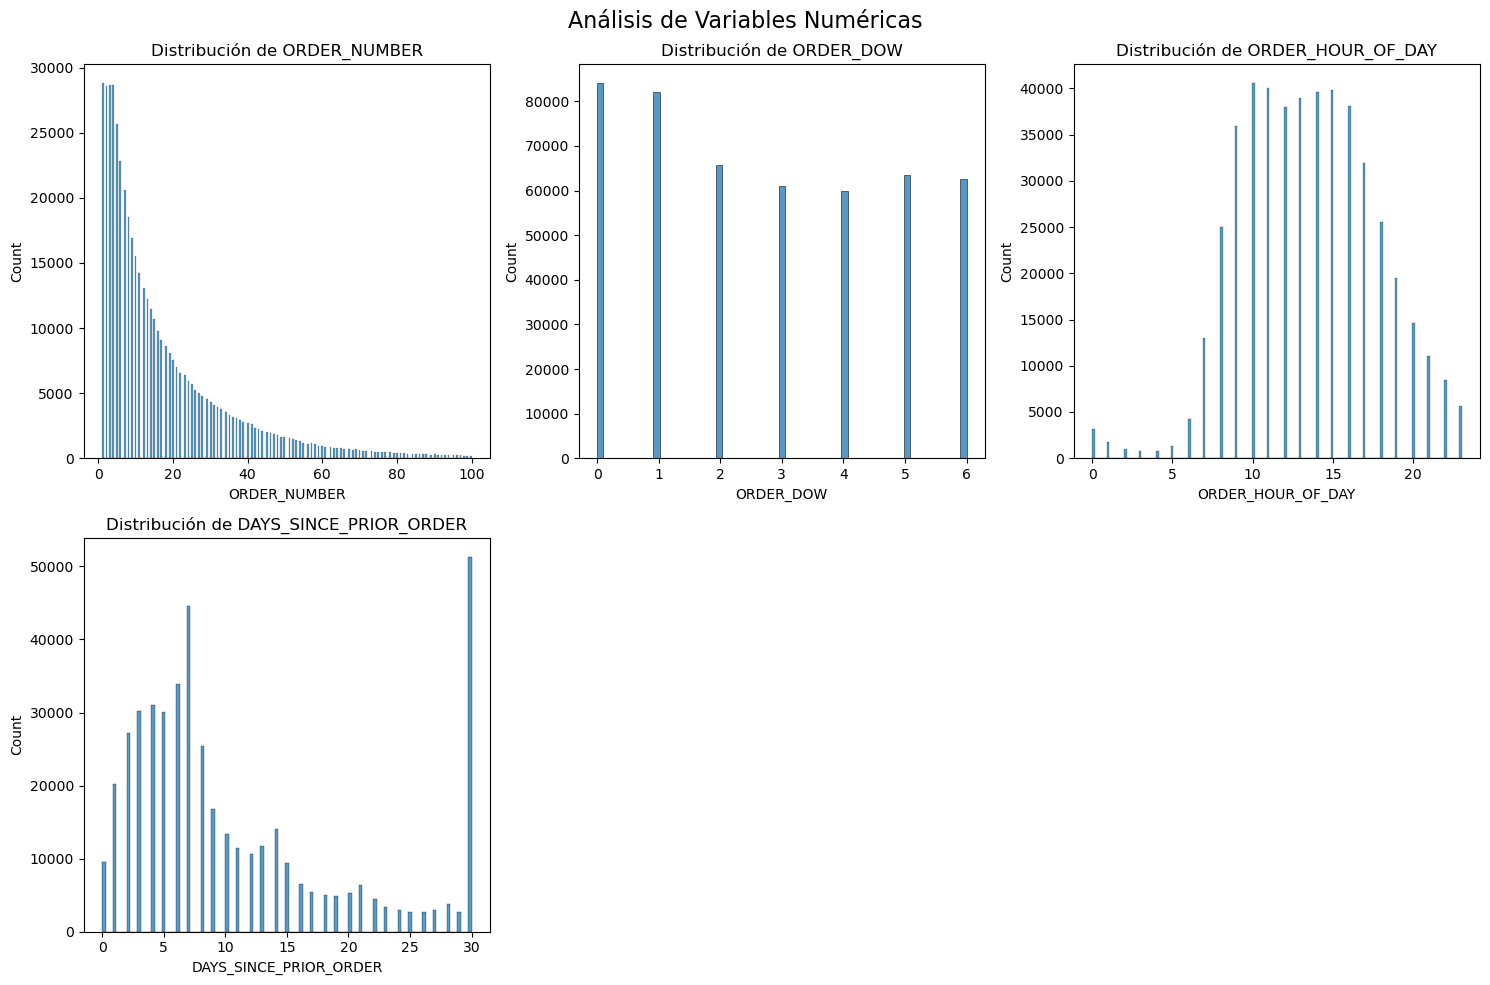

In [5]:
table_name = 'ORDERS'
result = conn.cursor().execute(f'SELECT ORDER_ID, USER_ID, ORDER_NUMBER, ORDER_DOW, ORDER_HOUR_OF_DAY, DAYS_SINCE_PRIOR_ORDER FROM {table_name}')
df = pd.DataFrame(result.fetchall(), columns=[desc[0] for desc in result.description])
analisis_exploratorio(table_name, df)

El análisis de la tabla ORDERS revela una dimensión considerable de 478,967 filas y 6 columnas. Aunque no hay valores ausentes en la mayoría de las columnas, se identificaron 28,819 registros con datos nulos en "DAYS_SINCE_PRIOR_ORDER". Además, se encontraron duplicados en cuanto a "ORDER_ID", tanto únicos (15) como totales (30), lo que puede afectar la integridad de los datos. Las distribuciones de variables como "ORDER_NUMBER" y "DAYS_SINCE_PRIOR_ORDER" muestran una inclinación hacia valores bajos, en el primer caso nos indica que la distribución de usuarios tiende a tener poco número de ordenes y en el segundo caso que la distribución de usuarios tiende a tener menos días desde la ultima orden, también se observa que 30 días es el número de días desde la ultima orden más frecuente. 'ORDER_DOW' muestra que los días con más ordenes serian el 0 y 1 que serían Ddomingo y lunes. Por otro lado "ORDER_HOUR_OF_DAY" presenta una distribución más uniforme con un sesgo negativo. También cabe destacar que hay 30182 outlayers y 6950 extreme_outlayers en "ORDER_NUMBER", los cuales serían usuarios con altos y muy altos números de ordenes.

In [6]:
df[df.duplicated(subset=['ORDER_ID'], keep=False)].sort_values(by='ORDER_ID')

,ORDER_ID,USER_ID,ORDER_NUMBER,ORDER_DOW,ORDER_HOUR_OF_DAY,DAYS_SINCE_PRIOR_ORDER
354993,391768,57671,19,3,2,10.0
371905,391768,57671,19,3,2,10.0
119251,408114,68324,4,3,2,18.0
321100,408114,68324,4,3,2,18.0
394347,467134,63189,21,3,2,2.0
250626,467134,63189,21,3,2,2.0
145574,794638,50898,24,3,2,2.0
99462,794638,50898,24,3,2,2.0
242618,1021560,53767,3,3,2,9.0
311713,1021560,53767,3,3,2,9.0


Al analizar detenidamente los duplicados de ORDER_ID se puede observar que son duplicados exactos, es decir que continen la misma información, por lo que quitando los duplicados se podria proceder.

In [7]:
df[df['DAYS_SINCE_PRIOR_ORDER'].isna()]

,ORDER_ID,USER_ID,ORDER_NUMBER,ORDER_DOW,ORDER_HOUR_OF_DAY,DAYS_SINCE_PRIOR_ORDER
28,133707,182261,1,3,10,NaN
96,787445,25685,1,6,18,NaN
100,294410,111449,1,0,19,NaN
103,2869915,123958,1,4,16,NaN
104,2521921,42286,1,3,18,NaN
...,...,...,...,...,...,...
478895,2589657,205028,1,0,16,NaN
478896,2222353,141211,1,2,13,NaN
478922,2272807,204154,1,1,15,NaN
478926,2499542,68810,1,4,19,NaN


Analizando los valores nulos de la columna "DAYS_SINCE_PRIOR_ORDER" se puede observar como los mismos coinciden con valores de 1 en "ORDER_NUMBER" lo que puede significar que son usuarios que solo han hecho una compra y por ello no tienen un valor en "DAYS_SINCE_PRIOR_ORDER". Aun así hay que confirmar que en todos los casos NaN en "DAYS_SINCE_PRIOR_ORDER" coincida con un 1 en "ORDER_NUMBER".

In [8]:
df[(df['DAYS_SINCE_PRIOR_ORDER'].isna())&(df['ORDER_NUMBER']!=1)]

,ORDER_ID,USER_ID,ORDER_NUMBER,ORDER_DOW,ORDER_HOUR_OF_DAY,DAYS_SINCE_PRIOR_ORDER


Ya que ningun NaN en "DAYS_SINCE_PRIOR_ORDER" tiene un valor distinto a 1 en "ORDER_NUMBER" queda confirmado que son usuarios nuevos que han realizado su primera compra, por lo que se podría rellenar esos valores NaN con ceros.

|                                            Análisis de la tabla ORDER_PRODUCTS                                            |
Dimensiones: (4545007, 4)

Estadísticos descriptivos básicos:
|                     | ORDER_ID   | PRODUCT_ID   |   ADD_TO_CART_ORDER | REORDERED   |
|:--------------------|:-----------|:-------------|--------------------:|:------------|
| Valores Únicos      | 450046     | 45573        |            64       | 2           |
| Media               | -          | -            |             8.35167 | -           |
| Desviación Estándar | -          | -            |             7.08037 | -           |
| Mínimo              | 4          | 1            |             1       | -           |
| Mediana             | -          | -            |             6       | -           |
| Máximo              | 3421079    | 49694        |            64       | -           |

Problemas de calidad:
|                               | ORDER_ID        | PRODUCT_ID      | ADD_TO_CART_ORD

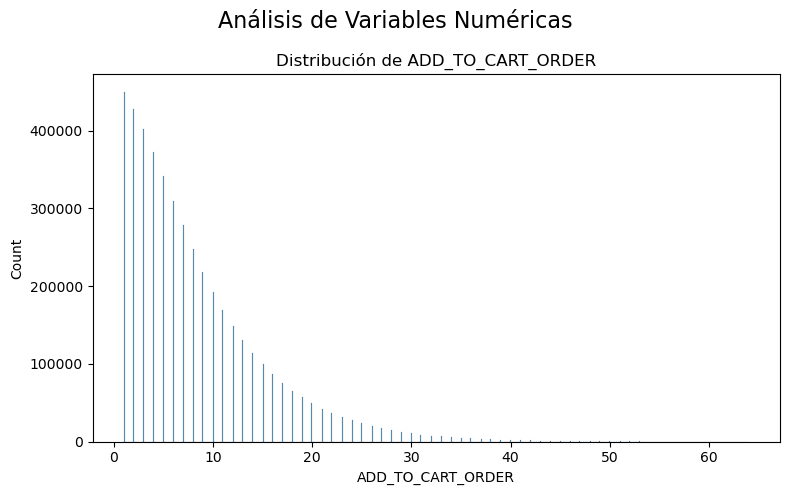

In [9]:
table_name = 'ORDER_PRODUCTS'
result = conn.cursor().execute(f'SELECT * FROM {table_name}')
df = pd.DataFrame(result.fetchall(), columns=[desc[0] for desc in result.description])
analisis_exploratorio(table_name, df)

El análisis de la tabla ORDER_PRODUCTS revela una dimensión considerable de 4,545,007 filas y 4 columnas. En cuanto a la calidad de los datos, se identificaron 836 valores nulos en "ADD_TO_CART_ORDER", mientras que las demás columnas están completas. Se encontró un alto número de duplicados en todas las columnas, siendo notable "ORDER_ID" con 4,094,961 duplicados únicos y 4,523,160 duplicados totales, y "PRODUCT_ID" con 4,499,434 duplicados únicos y 4,539,960 totales, lo cual es esperado dado que un pedido puede contener múltiples productos y un producto puede estar en múltiples pedidos. La variable "ADD_TO_CART_ORDER" tiene valores entre 1 y 64, con una media de 8.35 y una desviación estándar de 7.08, indicando que la mayoría de los pedidos contienen entre 1 y 15 productos, lo cual se puede ver reflejado en el histograma de la misma al presentar un sesgo positivo. Se identificaron 190,971 outliers superiores y 29,384 outliers extremos superiores en "ADD_TO_CART_ORDER", representando pedidos con un número inusualmente alto de productos. La columna "REORDERED" es de tipo booleano y presenta solo 2 valores únicos, indicando si el producto fue reordenado o no.

In [10]:
result = conn.cursor().execute(f'SELECT * FROM {table_name} JOIN ORDERS USING(ORDER_ID) JOIN PRODUCTS USING(PRODUCT_ID)')
df = pd.DataFrame(result.fetchall(), columns=[desc[0] for desc in result.description])
df[df['ADD_TO_CART_ORDER'].isna()].sort_values(by=['ORDER_ID', 'PRODUCT_ID'])         

,PRODUCT_ID,ORDER_ID,ADD_TO_CART_ORDER,REORDERED,ID_ORDER,USER_ID,ORDER_NUMBER,ORDER_DOW,ORDER_HOUR_OF_DAY,DAYS_SINCE_PRIOR_ORDER,PRODUCT_NAME,AISLE_ID,DEPARTMENT_ID
4000348,25753,9310,NaN,0,173141,199862,2,5,11,25.0,Organic Homestyle Waffles,52,1
1081298,1087,61355,NaN,0,283910,22906,3,5,11,11.0,Sunrise Crunchy Cinnamon Cereal,121,14
3185612,1203,61355,NaN,0,283910,22906,3,5,11,11.0,Crunchy Organic Dark Roasted Peanut Butter,88,13
2578475,1700,61355,NaN,0,283910,22906,3,5,11,11.0,White Cheddar Popcorn,23,19
3193650,3390,61355,NaN,0,283910,22906,3,5,11,11.0,Papaya,24,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
779039,63,3383594,NaN,0,232515,113238,13,1,10,30.0,Banana & Sweet Potato Organic Teething Wafers,92,18
3028326,15076,3383594,NaN,0,232515,113238,13,1,10,30.0,Graduates Fruit Pick-Ups Diced Apples,92,18
2529643,15424,3383594,NaN,1,232515,113238,13,1,10,30.0,Purified Water,115,7
4335659,46710,3383594,NaN,0,232515,113238,13,1,10,30.0,Graduates Waffle Wheels Banana Cream,92,18


Analizando más detalladamente los valores nulos de "ADD_TO_CART_ORDER" se puede observar que muchos comparten un mismo "ORDER_ID" lo cual puede indicar que son productos de una misma orden pero que por alguna razón se perdio el orden en el que fueron añadidos a al carro de compras. Entonces se podría decir que se trata de un caso MAR (Missing At Random) y aunque se los podría eliminar, también se podría optar por "marcarlos" rellenandolos con -1 por ejemplo, con esto podriamos calcular el total de productos en esas ordenes, lo cual podría resultar útil.

In [11]:
table_name = 'PRODUCTS'
result = conn.cursor().execute(f'SELECT * FROM {table_name}')
df = pd.DataFrame(result.fetchall(), columns=[desc[0] for desc in result.description])
analisis_exploratorio(table_name, df)

|                                               Análisis de la tabla PRODUCTS                                               |
Dimensiones: (49694, 4)

Estadísticos descriptivos básicos:
|                     | PRODUCT_NAME   | PRODUCT_ID   | AISLE_ID   | DEPARTMENT_ID   |
|:--------------------|:---------------|:-------------|:-----------|:----------------|
| Valores Únicos      | 48332          | 49694        | 134        | 21              |
| Media               | -              | -            | -          | -               |
| Desviación Estándar | -              | -            | -          | -               |
| Mínimo              | -              | 1            | 1          | 1               |
| Mediana             | -              | -            | -          | -               |
| Máximo              | -              | 49694        | 134        | 21              |

Problemas de calidad:
|                               | PRODUCT_ID      | PRODUCT_NAME       | AISLE_ID        | DEPA

El análisis de la tabla PRODUCTS revela una estructura de 49,694 filas y 4 columnas, representando el catálogo completo de productos. La columna "PRODUCT_NAME" contiene 48,332 valores únicos, con 104 nombres duplicados únicos y 207 duplicados totales, lo que podría indicar productos similares o variaciones del mismo artículo. Se identificaron 1,258 valores nulos en esta columna, lo que podría afectar la calidad de los datos. La clave primaria, PRODUCT_ID, no presenta duplicados, funcionando correctamente como identificador único. Por otro lado, AISLE_ID y DEPARTMENT_ID muestran un alto número de duplicados (49,560 y 49,673, respectivamente), lo cual es esperable dado que múltiples productos pueden pertenecer al mismo pasillo y departamento.

In [12]:
df[df['PRODUCT_NAME'].isna()]

,PRODUCT_ID,PRODUCT_NAME,AISLE_ID,DEPARTMENT_ID
37,38,None,100,21
71,72,None,100,21
109,110,None,100,21
296,297,None,100,21
416,417,None,100,21
...,...,...,...,...
49552,49553,None,100,21
49574,49575,None,100,21
49640,49641,None,100,21
49663,49664,None,100,21


Al analizzar los "PRODUCT_NAME" que tienen valores nulos podemos observar una posible relación con "AISLE_ID" y "DEPARTMENT_ID" ya que aparentemente todas las filas tienen 100 y 21 respectivamente en dichas columnas.

In [13]:
result = conn.cursor().execute(f'SELECT * FROM {table_name} JOIN AISLES USING(AISLE_ID) JOIN DEPARTMENTS USING(DEPARTMENT_ID)')
df = pd.DataFrame(result.fetchall(), columns=[desc[0] for desc in result.description])
print(df[(df['PRODUCT_NAME'].isna())])
print('Comprobación de DEPARMENT_ID = 21 y AISLE_ID = 100 (número de filas):', len(df[(df['PRODUCT_NAME'].isna())&(df['DEPARTMENT_ID']==21)&(df['AISLE_ID']==100)]))

       DEPARTMENT_ID  AISLE_ID  PRODUCT_ID PRODUCT_NAME    AISLE DEPARTMENT
37                21       100          38         None  missing    missing
71                21       100          72         None  missing    missing
109               21       100         110         None  missing    missing
296               21       100         297         None  missing    missing
416               21       100         417         None  missing    missing
...              ...       ...         ...          ...      ...        ...
49552             21       100       49553         None  missing    missing
49574             21       100       49575         None  missing    missing
49640             21       100       49641         None  missing    missing
49663             21       100       49664         None  missing    missing
49668             21       100       49669         None  missing    missing

[1258 rows x 6 columns]
Comprobación de DEPARMENT_ID = 21 y AISLE_ID = 100 (número de f

Para confirmar y aclarar la observación anterior se añadio las columnas "AISLE" y "DEPARTMENT", con esto podemos observar que son productos desconocidos para las tres tablas por ello tienen la etiqueta missing tanto en "AISLE" y "DEPARTMENT". Adicionalmente se comprobó que efectivamente todos los registros con "PRODUCT_NAME" nulo tienen a su vez "DEPARMENT_ID" = 21 y "AISLE_ID" = 100. Por estas razones podriamos rellenar esos nulos con el nombre "Desconocido" al tratarse de un caso MNAR (Missing Not At Random)

In [14]:
df['PRODUCT_NAME'] = df['PRODUCT_NAME'].apply(lambda x: x.lower().strip() if pd.notna(x) else x)
df[(df.duplicated(subset=['PRODUCT_NAME'], keep=False))&(df['PRODUCT_NAME'].notnull())].sort_values(by=['PRODUCT_NAME', 'PRODUCT_ID'])

,DEPARTMENT_ID,AISLE_ID,PRODUCT_ID,PRODUCT_NAME,AISLE,DEPARTMENT
23339,11,25,23340,18-in-1 hemp peppermint pure-castile soap,soap,personal care
31844,11,25,31845,18-in-1 hemp peppermint pure-castile soap,soap,personal care
13152,13,19,13153,aged balsamic vinegar of modena,oils vinegars,pantry
19941,13,19,19942,aged balsamic vinegar of modena,oils vinegars,pantry
22582,15,95,22583,albacore solid white tuna in water,canned meat seafood,canned goods
...,...,...,...,...,...,...
49442,11,47,49443,vitamin d3 5000 iu,vitamins supplements,personal care
21366,15,95,21367,wild sardines in spring water,canned meat seafood,canned goods
40093,15,95,40094,wild sardines in spring water,canned meat seafood,canned goods
1826,15,81,1827,yams cut sweet potatoes in syrup,canned jarred vegetables,canned goods


En cuanto a los duplicados en al columna "PRODUCT_NAME" podemos observar que son registros duplicados pues presentan la misma información en todas las columnas excepto "PRODUCT_ID", pero eso es de esperarse pues se los estaba contando como productos distintos. Esto probablemente se debía a diferencias en caracteres, pues para la duplicidad se puso en minúscula todos los "PRODUCT_NAME". En este caso se podría eliminar las filas duplicadas y mantener aquellas con "PRODUCT_ID" inferior, esto claro después de rehacer las relaciones con las demás tablas.

## Conclusiones

1. **AISLES**  
   - **Estructura:** 134 filas y 2 columnas.  
   - **Calidad:** 134 valores únicos en ambas columnas, sin valores ausentes, duplicados o inconsistencias.  
   - **Observación:** La tabla se encuentra en buen estado y puede ser utilizada tal como está en análisis posteriores, representando los pasillos de la tienda.

2. **DEPARTMENTS**  
   - **Estructura:** 21 filas y 2 columnas.  
   - **Calidad:** 21 valores únicos en ambas columnas, sin valores ausentes, duplicados o inconsistencias.  
   - **Observación:** La tabla se encuentra limpia y es adecuada para el análisis, representando los departamentos de la tienda.

3. **ORDERS**  
   - **Estructura:** 478,967 filas y 6 columnas.  
   - **Problemas detectados:**  
     - **Valores nulos:** 28,819 registros en la columna *DAYS_SINCE_PRIOR_ORDER*. Se ha identificado que estos corresponden a órdenes con *ORDER_NUMBER* igual a 1 (usuarios nuevos).  
     - **Duplicados:** Se encontraron duplicados exactos en *ORDER_ID* (15 registros únicos duplicados en 30 totales).  
   - **Observaciones adicionales:**  
     - La distribución de *ORDER_NUMBER* y *DAYS_SINCE_PRIOR_ORDER* indica que la mayoría de los usuarios realizan pocas órdenes y tienen pocos días transcurridos entre ellas (30 días es el valor más frecuente en *DAYS_SINCE_PRIOR_ORDER*).  
     - Se detectan outliers en *ORDER_NUMBER* (30,182 outliers y 6,950 extreme outlayers), indicando usuarios con un número inusualmente alto de órdenes.

4. **ORDER_PRODUCTS**  
   - **Estructura:** 4,545,007 filas y 4 columnas.  
   - **Problemas detectados:**  
     - **Valores nulos:** 836 registros en *ADD_TO_CART_ORDER*. Se observa que estos nulos comparten el mismo *ORDER_ID*, lo que sugiere un caso MAR (Missing At Random) que afecta la secuencia en la que se agregan los productos al carrito.  
     - **Duplicados:**  
       - *ORDER_ID* y *PRODUCT_ID* presentan altos números de duplicados, lo cual es esperado debido a la naturaleza de la tabla (un pedido puede incluir múltiples productos y viceversa).  
     - **Distribución:** La mayoría de los pedidos tienen entre 1 y 15 productos, con un sesgo positivo en *ADD_TO_CART_ORDER*. Se detectan además numerosos outliers (190,971 outliers superiores y 29,384 extreme outlayers).

5. **PRODUCTS**  
   - **Estructura:** 49,694 filas y 4 columnas, representando el catálogo completo.  
   - **Problemas detectados:**  
     - **Valores nulos:** 1,258 registros en *PRODUCT_NAME*.  
     - **Duplicados en nombres:** Se encontraron 104 nombres duplicados únicos (207 en total), lo que podría deberse a variaciones en caracteres o a la existencia de productos similares.  
     - **Observación adicional:** Los productos con *PRODUCT_NAME* nulo tienen asociados *AISLE_ID = 100* y *DEPARTMENT_ID = 21*, lo cual sugiere que son productos "desconocidos" en el catálogo.  
   - **Clave primaria:** *PRODUCT_ID* es único, por lo que la integridad identificatoria se mantiene.

---

## Plan de Acción: Transformación y Curación de Datos

### 1. Limpieza de valores ausentes
- **ORDERS:**  
  - Verificar que todos los registros con *DAYS_SINCE_PRIOR_ORDER* nulos correspondan a órdenes con *ORDER_NUMBER* = 1.  
  - **Acción:** Imputar estos nulos con 0, indicando que no existe un día transcurrido ya que es la primera orden.

- **ORDER_PRODUCTS:**  
  - Analizar los 836 valores nulos en *ADD_TO_CART_ORDER*.  
  - **Acción:** Imputar con un valor distintivo (por ejemplo, -1) para marcar la ausencia del orden en que se agregó el producto, lo cual permitirá luego calcular totales por orden sin perder información.

- **PRODUCTS:**  
  - Los 1,258 registros con *PRODUCT_NAME* nulo se asocian consistentemente a *AISLE_ID = 100* y *DEPARTMENT_ID = 21*.  
  - **Acción:** Imputar estos valores nulos con el nombre "Desconocido", tratándose de un caso MNAR (Missing Not At Random).

### 2. Eliminación o consolidación de duplicados
- **ORDERS:**  
  - Detectados duplicados exactos en *ORDER_ID*.  
  - **Acción:** Eliminar los registros duplicados para asegurar la integridad de la información.

- **ORDER_PRODUCTS:**  
  - Los duplicados en *ORDER_ID* y *PRODUCT_ID* son esperados por la naturaleza de la tabla.  
  - **Acción:** Mantener los duplicados naturales, pero revisar y eliminar cualquier duplicado que no corresponda a la lógica del negocio.

- **PRODUCTS:**  
  - Se observan duplicados en *PRODUCT_NAME* (excluyendo el identificador único *PRODUCT_ID*), lo que puede deberse a diferencias en caracteres (por ejemplo, mayúsculas/minúsculas).  
  - **Acción:**  
    - Normalizar los nombres (por ejemplo, convertir a minúsculas) para facilitar la detección de duplicados reales.  
    - Consolidar registros duplicados, conservando el registro con el *PRODUCT_ID* inferior y ajustando las relaciones con otras tablas si fuera necesario.

### 3. Conversión de tipos de datos y normalización
- **Revisión y validación de tipos:**  
  - Verificar que cada columna tenga el tipo de dato adecuado (por ejemplo, *REORDERED* en ORDER_PRODUCTS es booleano).  
- **Normalización de cadenas:**  
  - Convertir los nombres de productos a un formato uniforme (minúsculas o mayúsculas) para evitar duplicidades artificiales.
- **Integridad referencial:**  
  - Revisar las relaciones entre las tablas (ej. la correspondencia entre *AISLE_ID* y *DEPARTMENT_ID* en PRODUCTS con las tablas AISLES y DEPARTMENTS) para asegurar consistencia luego de la limpieza.

### 4. Manejo de outliers y validaciones adicionales
- **Outliers en ORDERS y ORDER_PRODUCTS:**  
  - Revisar los registros identificados como outliers en *ORDER_NUMBER* y *ADD_TO_CART_ORDER*.  
  - **Acción:** Evaluar si estos valores extremos son válidos o requieren transformaciones adicionales (por ejemplo, escalado o categorización) para no afectar los análisis futuros.

### 5. Documentación y pruebas finales
- **Documentar cada paso:**  
  - Registrar todas las transformaciones realizadas, incluyendo imputaciones, eliminación de duplicados, conversiones de tipos y normalizaciones.  
- **Validaciones:**  
  - Ejecutar pruebas de calidad de datos para confirmar que las tablas, tras la transformación, no presentan inconsistencias y están listas para análisis posteriores.
